In [2]:
%load_ext autoreload
%autoreload 2
#  base environment
from notebook_setup import *

import os
import dotenv
import numpy as np
import functools

# noise generation
from noise import pnoise2, pnoise3
from joblib import Parallel, delayed

# visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from torch.utils.data import DataLoader
from tqdm import tqdm
import warnings

# load environment variables
_ = dotenv.load_dotenv(override=True)

from training.networks.neuraloperator.multipole import MPGKScoreOperator
from data.synthetic.low_frequency import PinkNoise1D
from training.noising_kernels import RBFIrregular
from training.collate import CollateMesh, CompositeCollate, MakeConditional
from training.networks.neuraloperator.multipole import MPGKScoreOperator
from training.loss import EDMLoss
from training.augment_pipe import AugmentPipe
from samplers import EDMSampler
from training.networks.neuraloperator.precond import EDMPreconditioner
import datetime
import pickle
from samplers import ImputationEDMSampler

# One Dimensional Re-analysis

Here, we take a pretrained denoising diffusion operator and try to perform in-painting on a 1D signal with it.


In [3]:
sigma_min = 0.002
sigma_max = 80
sigma_data = 1.0
denoiser_network = MPGKScoreOperator(
    coord_dim=1,
    latent_channels=32, # 128
    radius=0.01,
    radii_mult=[2, 4, 8],
    iter_count=3, # 8
)
# precondition the network for better performance
denoiser_network = EDMPreconditioner(
    score_net=denoiser_network,
    sigma_min=sigma_min,
    sigma_max=sigma_max,
    sigma_data=sigma_data,
)
denoiser_network.load_state_dict(torch.load("outputs/checkpoints/notebooks/more_expressive-30Oct-2338/denoiser_model.pth"))

/tmp/ipykernel_3835047/3096227517.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoiser_network.load_state_dict(torch.load("outputs/checkpoints/notebooks/more_expres

<All keys matched successfully>

Test the model for normal generation:


Sampling: 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


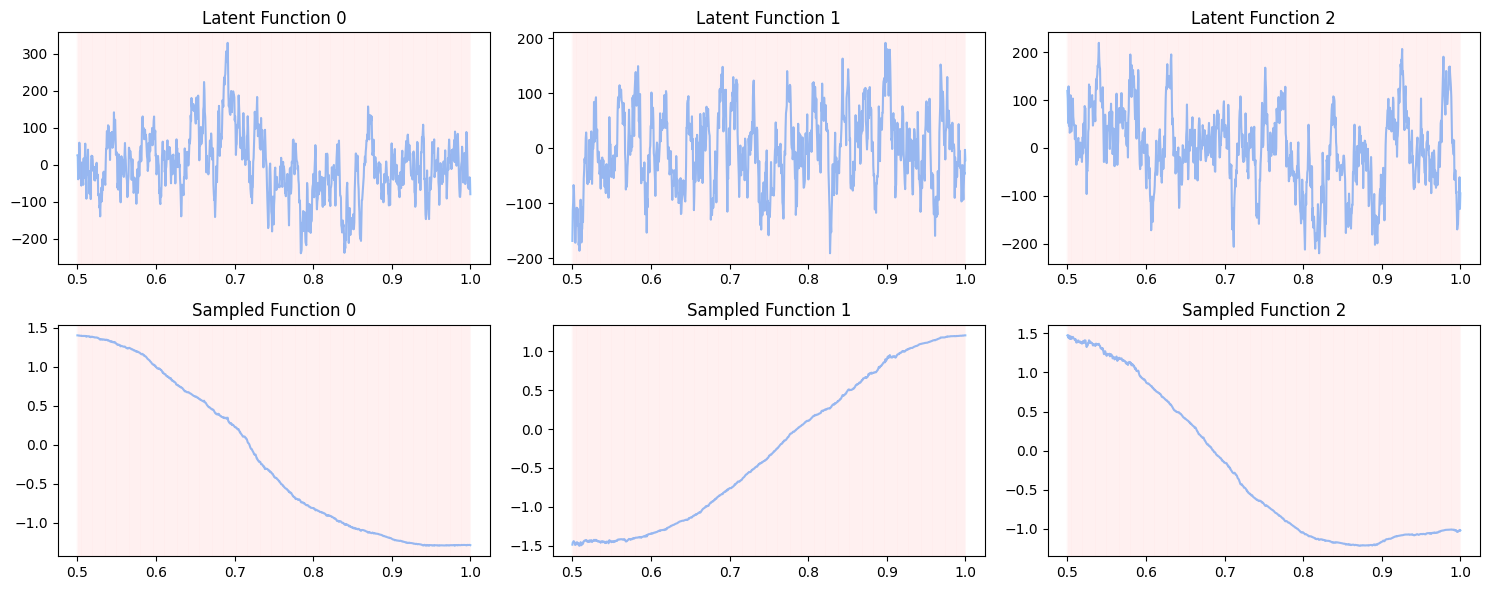

In [43]:
num_steps = 30
batch_size = 3
rho = 7
resolution = 1000
generation_seed=42
sigma_min = 0.2
sigma_max = 80
###

noising_kernel = RBFIrregular()
torch.random.manual_seed(generation_seed)
generation_coords = torch.linspace(0.5, 1, resolution)
# shuffle the coordinates
generation_coords = generation_coords[torch.randperm(resolution)]
_, shuffle_idx = torch.sort(generation_coords)
generation_coords = generation_coords.unsqueeze(0)
# print(generation_coords.shape, coords.shape)

sampler = EDMSampler(verbose=True)
with torch.no_grad():
    latents = sigma_max * noising_kernel.sample(
        coords=generation_coords.unsqueeze(0).repeat(batch_size, 1, 1),
    )
    samples = sampler(
        net=denoiser_network,
        coords=generation_coords,
        latents=latents,
        conditioning=None,
        num_steps=num_steps, 
        sigma_min=sigma_min, 
        sigma_max=sigma_max, 
        rho=rho,
    )
    fig, axes = plt.subplots(2, batch_size, figsize=(15, 6))
    for i in range(batch_size):
        ax = axes[0, i]
        ax.plot(generation_coords.squeeze()[shuffle_idx], latents[i].squeeze()[shuffle_idx])
        ax.set_title(f"Latent Function {i}")
        for x in generation_coords.squeeze():
            ax.axvline(x, color="red", alpha=0.01)
        ax = axes[1, i]
        ax.plot(generation_coords.squeeze()[shuffle_idx], samples[i].squeeze()[shuffle_idx])
        ax.set_title(f"Sampled Function {i}")
        for x in generation_coords.squeeze():
            ax.axvline(x, color="red", alpha=0.01)
    plt.tight_layout()

Train a denoising diffusion operator using the denoising loss.


In [32]:
dset = PinkNoise1D(
    total_count=5000,
    num_samples=100,
    low_pass_threshold=0.02,
    make_irregular=True,
    bernoulli_p=0.99,
    fixed_irregularity_seed=42,
)

Sampling with imputation: 100%|██████████| 30/30 [00:01<00:00, 24.77it/s]


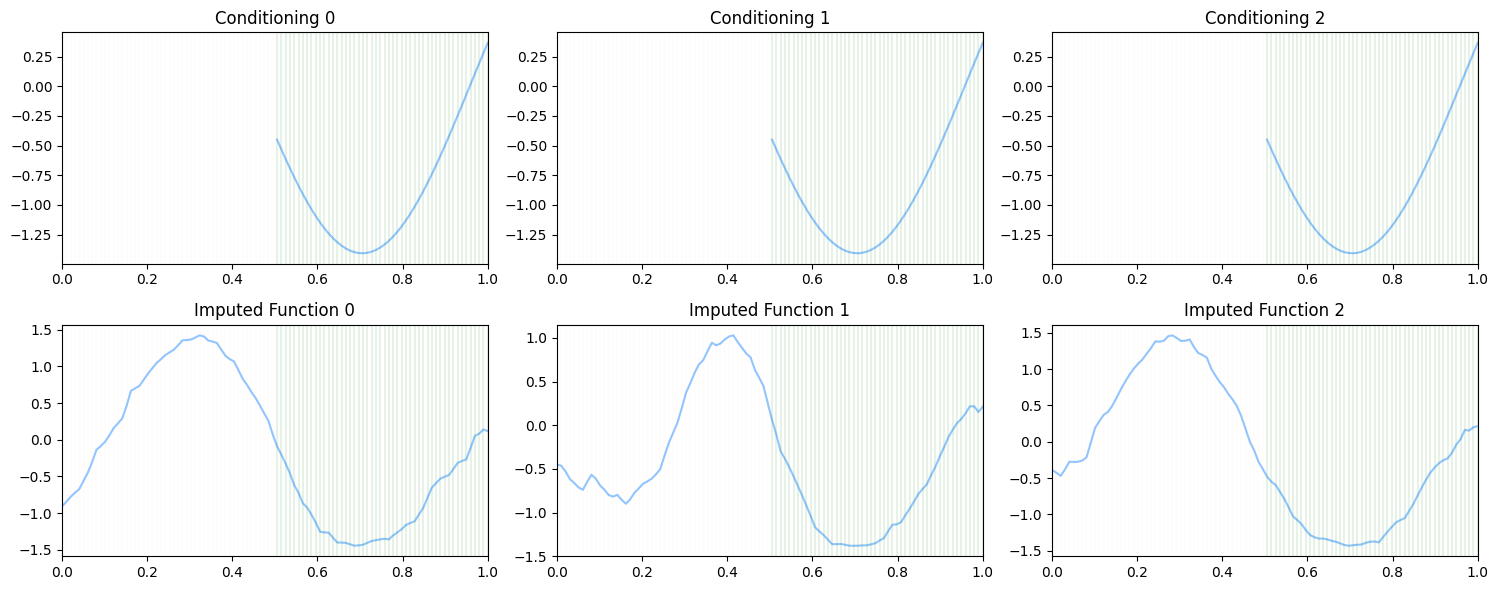

In [42]:
num_steps = 30
batch_size = 3
rho = 7
resolution = 100
generation_seed=999
sigma_min = 0.2
sigma_max = 80
###

noising_kernel = RBFIrregular()

ref_coords, ref_values = dset[0]   
ref_coords = ref_coords[:, len(ref_values) // 2:]
ref_values = ref_values[len(ref_values) // 2:]

torch.random.manual_seed(generation_seed)
generation_coords = []
for t in np.linspace(0, 1, resolution):
    if not (torch.any(ref_coords - torch.tensor(t).float() <= 1e-2) and torch.any(ref_coords - torch.tensor(t).float() >= -1e-2)):
        generation_coords.append(t)
generation_coords = torch.tensor(generation_coords).unsqueeze(0).float()

fig, axes = plt.subplots(2, batch_size, figsize=(15, 6))

all_coords = torch.cat([generation_coords, ref_coords], dim=1)

inp_rbf = all_coords.unsqueeze(0)
rbf_noise = noising_kernel.sample(inp_rbf)
sampler = ImputationEDMSampler(noising_kernel=RBFIrregular(), verbose=True)

with torch.no_grad():
    for i in range(batch_size):
        samples = sampler(
            net=denoiser_network,
            coords=generation_coords,
            coord_ref=ref_coords,
            values_ref=ref_values,
            conditioning=None,
            num_steps=num_steps, 
            sigma_max=sigma_max,
            sigma_min=sigma_min,
            rho=rho,
        )
        ax = axes[0, i]
        all_coords = torch.cat([generation_coords, ref_coords], dim=1)
        ax.plot(ref_coords.squeeze(), ref_values.squeeze())
        ax.set_title(f"Conditioning {i}")
        for x in generation_coords.squeeze():
            ax.axvline(x, color="red", alpha=0.01)
        for x in ref_coords.squeeze():
            ax.axvline(x, color="green", alpha=0.1)
        ax.set_xlim([0, 1])

        # sample after re-analysis
        ax = axes[1, i]
        sorted_coords, coord_idx = torch.sort(all_coords.squeeze())
        ax.plot(sorted_coords, samples.squeeze()[coord_idx])
        ax.set_title(f"Imputed Function {i}")
        for x in generation_coords.squeeze():
            ax.axvline(x, color="red", alpha=0.01)
        for x in ref_coords.squeeze():
            ax.axvline(x, color="green", alpha=0.1)
        ax.set_xlim([0, 1])
plt.tight_layout()

torch.Size([1, 810]) torch.Size([1, 100])


Sampling with imputation: 100%|██████████| 60/60 [00:11<00:00,  5.10it/s]


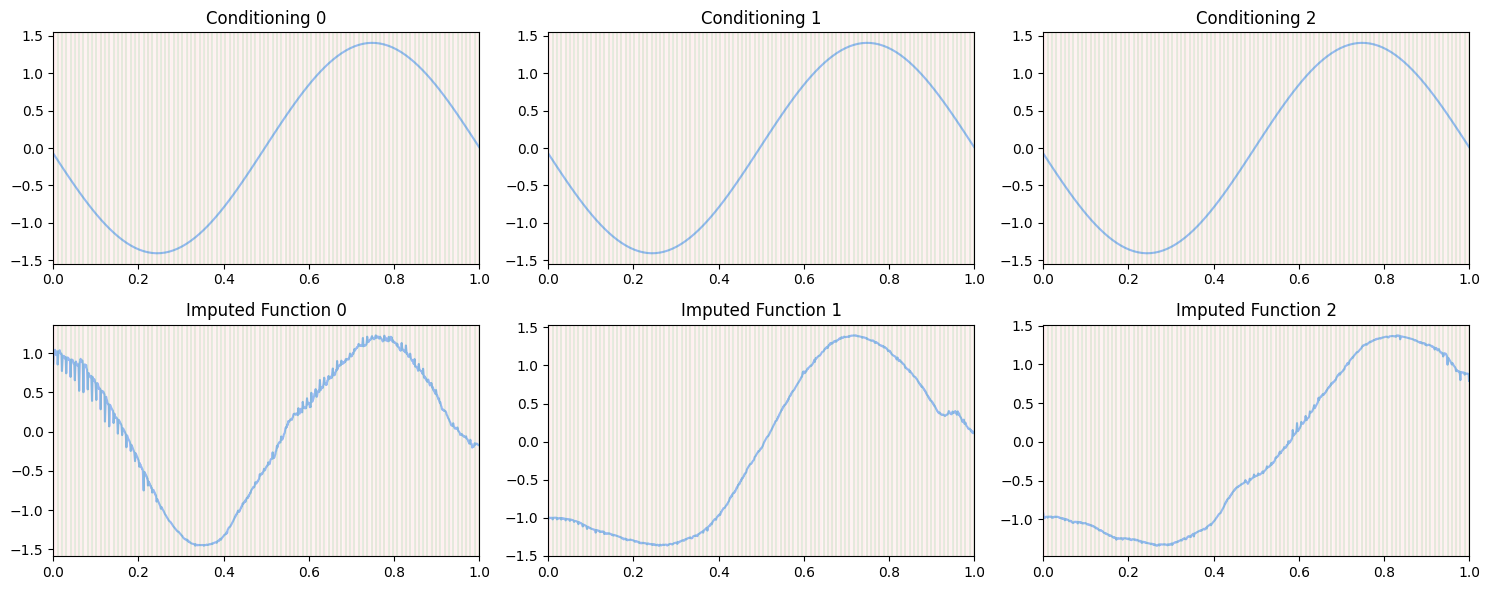

In [57]:
num_steps = 60
batch_size = 3
rho = 7
resolution = 1000
generation_seed=999
sigma_min = 0.2
sigma_max = 80
###

noising_kernel = RBFIrregular()

ref_coords, ref_values = dset[0]   

torch.random.manual_seed(generation_seed)
generation_coords = []
for t in np.linspace(0, 1, resolution):
    dist_from_t_to_ref = torch.abs(ref_coords - torch.tensor(t).float())
    if not torch.any(dist_from_t_to_ref <= 1e-3):
        generation_coords.append(t)
generation_coords = torch.tensor(generation_coords).unsqueeze(0).float()
print(generation_coords.shape, ref_coords.shape)

fig, axes = plt.subplots(2, batch_size, figsize=(15, 6))
sampler = ImputationEDMSampler(noising_kernel=RBFIrregular(), verbose=True)

with torch.no_grad():
    for i in range(batch_size):
        samples = sampler(
            net=denoiser_network,
            coords=generation_coords,
            coord_ref=ref_coords,
            values_ref=ref_values,
            conditioning=None,
            num_steps=num_steps, 
            sigma_max=sigma_max,
            sigma_min=sigma_min,
            rho=rho,
        )
        ax = axes[0, i]
        all_coords = torch.cat([generation_coords, ref_coords], dim=1)
        ax.plot(ref_coords.squeeze(), ref_values.squeeze())
        ax.set_title(f"Conditioning {i}")
        for x in generation_coords.squeeze():
            ax.axvline(x, color="red", alpha=0.01)
        for x in ref_coords.squeeze():
            ax.axvline(x, color="green", alpha=0.1)
        ax.set_xlim([0, 1])

        # sample after re-analysis
        ax = axes[1, i]
        sorted_coords, coord_idx = torch.sort(all_coords.squeeze())
        ax.plot(sorted_coords, samples.squeeze()[coord_idx])
        ax.set_title(f"Imputed Function {i}")
        for x in generation_coords.squeeze():
            ax.axvline(x, color="red", alpha=0.01)
        for x in ref_coords.squeeze():
            ax.axvline(x, color="green", alpha=0.1)
        ax.set_xlim([0, 1])
plt.tight_layout()